# Tello Vision Telemetry Lab

## 3D Computer Vision for Spotlight tracking mode

### Description: 3D person localization referred to drone position (polar map)
See data explanation at [the end of the notebook](#data-explanation).

### Index:
* [Telemetry Analysis Setup](#analysis-setup)
* [Detection and Person Estimated Distance ](#estimated-distance)
* [Detection and Horizontal Angular Tracking Error (apparent from the image center)](#angle-error)
* [Drone Centered Person Detection Polar Map (distance and absolute angle)](#polar-map)
* [Select a track for the ongoing analysis](#track-selection)
* [Animation: Drone Centered Person Detection Polar Map](#polar-animation)
* [Drone tof flight and detected face estimated heigth](#drone-heigth)
* [3D Detection tracks relative to drone position](#3d-tracks)
* [Animation: 3D Detection tracks relative to drone position](#3d-animation)
* [Telemetry Data Explanation](#data-explanation)
* [Telemetry Data Filtering](#data-filtering)

### Telemetry Analysis Setup <a class="anchor" id="analysis-setup"></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import numpy as np
%matplotlib inline

In [7]:
#Read Data
df = pd.read_csv('data/tv_telemetry_210324_115725_demo_spotlight.txt')
df.tail(3)

,timestamp,trackMode,telSeqId,personCount,personConfidence,faceXPx,faceYPx,faceRadiusPx,angle_err,estimatedDistance,...,Uy,pitch,roll,yaw,vx,vy,vz,tof,batt,temp
2495,259061,1,14,0,63,288,51,0,-13,188,...,0,0,1,129,0,1,0,10,26,76
2496,259162,1,14,0,63,288,51,0,-13,188,...,0,0,1,129,0,1,0,10,26,76
2497,259263,1,14,0,63,288,51,0,-13,188,...,0,0,1,129,0,1,0,10,26,76


In [3]:
#Extract data columns
timestamp=df["timestamp"]
trackMode=df["trackMode"]
telSeqId=df["telSeqId"]
personCount=df["personCount"]
personConfidence=df["personConfidence"]
faceXPx=df["faceXPx"]
faceYPx=df["faceYPx"]
faceRadius=df["faceRadiusPx"]
theta=df["angle_err"]
estimatedDistance=df["estimatedDistance"]
yPos=df["estimatedYPos"]
Uyaw=df["Uyaw"]
Ux=df["Ux"]
Uy=df["Uy"]
Uz=df["Uz"]
pitch=df["pitch"]
roll=df["roll"]
yaw=df["yaw"]
vx=df["vx"]
vy=df["vy"]
vz=df["vz"]
tof=df["tof"]
batt=df["batt"]
temp=df["temp"]


In [4]:
#Figures dpi
dpiSelected=72

### Detection and Person Estimated Distance <a class="anchor" id="estimated-distance"></a>

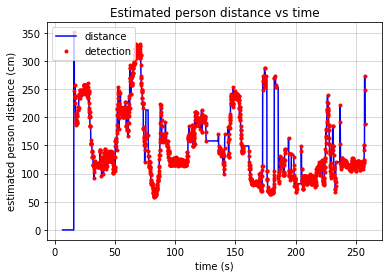

In [5]:
%matplotlib inline
plt.plot(timestamp/1000,estimatedDistance,'b')
plt.plot(timestamp[personCount>0]/1000,estimatedDistance[personCount>0],'r.')
plt.xlabel('time (s)')
plt.ylabel('estimated person distance (cm)')
plt.title('Estimated person distance vs time')
plt.legend(['distance','detection'],loc='upper left')
plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.grid(b=True, which='minor', color='#666666', linestyle='-',alpha=0.3)
plt.savefig("out/jpg/spotlight3d/estimatedDistance.jpg",dpi=dpiSelected)
plt.show()

### Detection and Horizontal Angular Tracking Error (apparent from the image center) <a class="anchor" id="angle-error"></a>

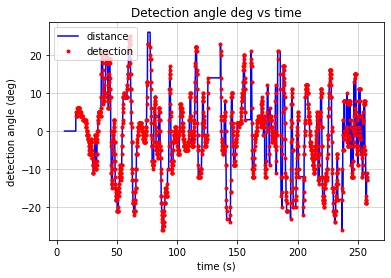

In [7]:
plt.plot(timestamp/1000,theta,'b')
plt.plot(timestamp[personCount>0]/1000,theta[personCount>0],'r.')
plt.xlabel('time (s)')
plt.ylabel('detection angle (deg)')
plt.title('Detection angle deg vs time')
plt.legend(['distance','detection'],loc='upper left')
plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.grid(b=True, which='minor', color='#666666', linestyle='-',alpha=0.3)
plt.savefig("out/jpg/spotlight3d/angle-tracking.jpg",dpi=dpiSelected)
plt.show()

### Drone Centered Person Detection Polar Map (distance and absolute angle) <a class="anchor" id="polar-map"></a>

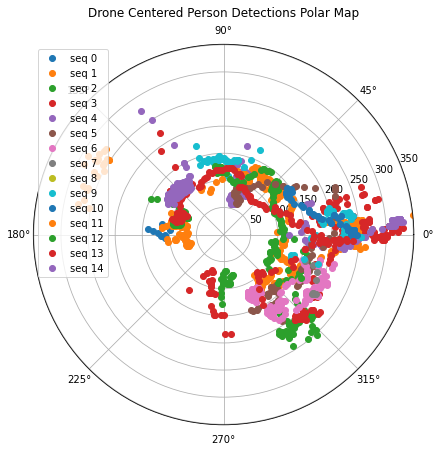

In [8]:
#Display odometry track by telSeqId (Sequential Id marked during the flight)
%matplotlib inline
N=np.max(telSeqId)
thetaDet=theta[personCount>0]
yawDet=yaw[personCount>0]
estimatedDistanceDet=estimatedDistance[personCount>0]
fig0 = plt.figure(figsize=(7,7))
ax = fig0.add_subplot(111, polar=True)
for i in range(N+1):
    ax.plot((thetaDet[telSeqId==i]+yawDet[telSeqId==i])*np.pi/180,estimatedDistanceDet[telSeqId==i],'o',label='seq {:d}'.format(i))
ax.set_rmax(np.max(estimatedDistanceDet))
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(22)  # Move radial labels away from plotted line
ax.grid(True)
ax.legend(loc='upper left')
ax.set_title("Drone Centered Person Detections Polar Map", va='bottom')
plt.savefig("out/jpg/spotlight3d/polar-map-2d.jpg",dpi=dpiSelected)
plt.show()

### Select a track for the ongoing analysis <a class="anchor" id="track-selection"></a>

In [9]:
#Choose a track that will be used for the rest of the analysis
seqId=13

dataSelector=(telSeqId==seqId)
print("Seq - Data")
print(telSeqId.value_counts())
if(len(telSeqId[dataSelector])>0):
    print("\nSequence {:d} has {:d}/{:d} data in current telemetry file".format(seqId,len(telSeqId[dataSelector]),len(telSeqId)))
else:
    print("\nSequence {:d} not present in current telemetry file".format(seqId))


Seq - Data
1     321
13    282
6     277
12    224
11    201
14    199
10    182
4     156
9     138
5     126
3     115
2      98
0      70
7      55
8      54
Name: telSeqId, dtype: int64

Sequence 13 has 282/2498 data in current telemetry file


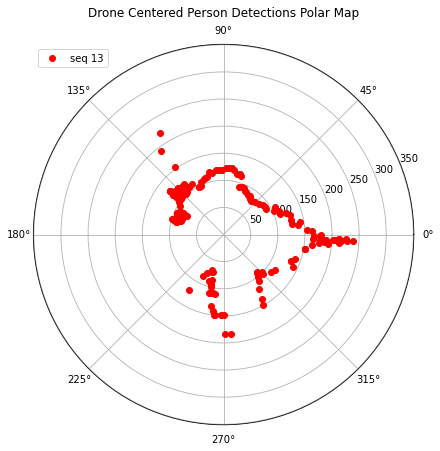

In [11]:
#Display detection track by telSeqId (Sequential Id marked during the flight)
%matplotlib inline
N=np.max(telSeqId)
thetaDet=theta[personCount>0]
yawDet=yaw[personCount>0]
estimatedDistanceDet=estimatedDistance[personCount>0]
fig0 = plt.figure(figsize=(7,7))
ax = fig0.add_subplot(111, polar=True)
ax.plot((thetaDet[telSeqId==seqId]+yawDet[telSeqId==seqId])*np.pi/180,estimatedDistanceDet[telSeqId==seqId],'ro',label='seq {:d}'.format(seqId))
ax.set_rmax(np.max(estimatedDistanceDet))
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(22)  # Move radial labels away from plotted line
ax.grid(True)
ax.legend(loc='upper left')
ax.set_title("Drone Centered Person Detections Polar Map", va='bottom')
plt.savefig("out/jpg/spotlight3d/polar-map-2d-selected-track.jpg",dpi=dpiSelected)
plt.show()

### Animation: Drone Centered Person Detection Polar Map <a class="anchor" id="polar-animation"></a>

<IPython.core.display.Javascript object>


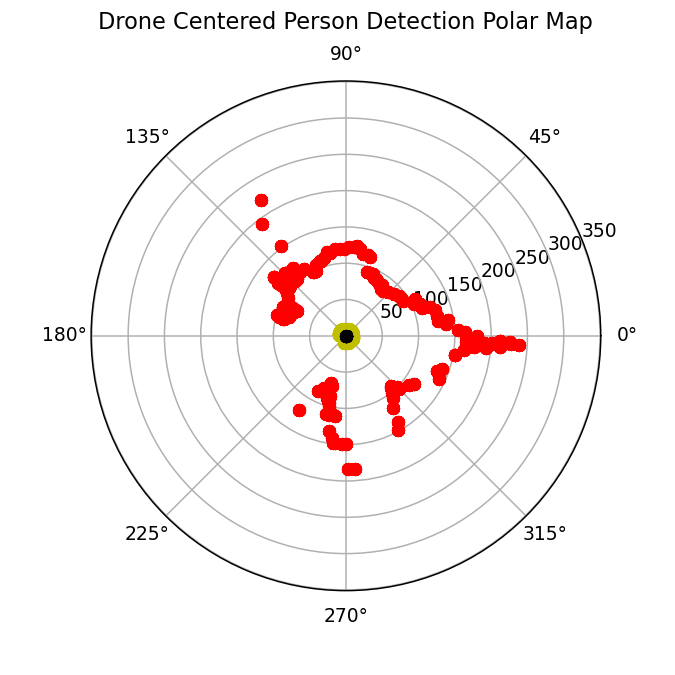

In [12]:
%matplotlib notebook
fig3 = plt.figure(figsize=(5,5))
ax = fig3.add_subplot(111, polar=True)
thetaDet=theta[personCount>0]
yawDet=yaw[personCount>0]
estimatedDistanceDet=estimatedDistance[personCount>0]
tofDet=tof[personCount>0]
yPosDet=yPos[personCount>0]
thetaf=np.array(thetaDet[telSeqId==seqId])
yawf=np.array(yawDet[telSeqId==seqId])
estimatedDistancef=np.array(estimatedDistanceDet[telSeqId==seqId])
toff=np.array(tofDet[telSeqId==seqId])
yPosf=np.array(yPosDet[telSeqId==seqId])
 
def draw_data(i):       
    # Clear
    #ax.cla()
    ax.plot((thetaf[i:i+9]+yawf[i:i+9])*np.pi/180,estimatedDistancef[i:i+9],'ro',label='person')
    ax.plot(0,0,'ko',label='drone')
    ax.plot(yawf[i]*np.pi/180,10,'yo',label='camera')
    ax.set_rlim(0,np.max(estimatedDistancef))
    ax.set_title("Drone Centered Person Detection Polar Map", va='bottom')
    ax.set_rmax(np.max(estimatedDistanceDet))
    ax.set_rlabel_position(22)  # Move radial labels away from plotted line
    #ax.legend(loc='upper left')


anim = animation.FuncAnimation(fig3, draw_data, interval=50, frames=len(telSeqId==seqId)-10, repeat=False)    
plt.show()

### Drone tof flight and detected face estimated heigth <a class="anchor" id="drone-heigth"></a>

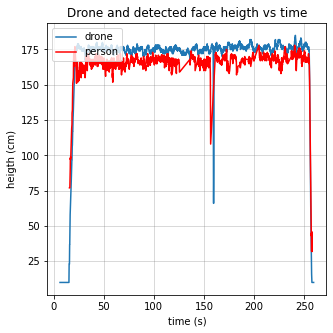

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(5,5))
plt.plot(timestamp/1000,tof,timestamp[personCount>0]/1000,tof[personCount>0]-yPos[personCount>0],'r')
plt.xlabel('time (s)')
plt.ylabel('heigth (cm)')
plt.title('Drone and detected face heigth vs time')
plt.legend(['drone','person'],loc='upper left')
plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.grid(b=True, which='minor', color='#666666', linestyle='-',alpha=0.3)
plt.savefig("out/jpg/spotlight3d/drone-face-heigth.jpg",dpi=dpiSelected)

plt.show()

### 3D Detection tracks relative to drone position <a class="anchor" id="3d-tracks"></a>

<IPython.core.display.Javascript object>


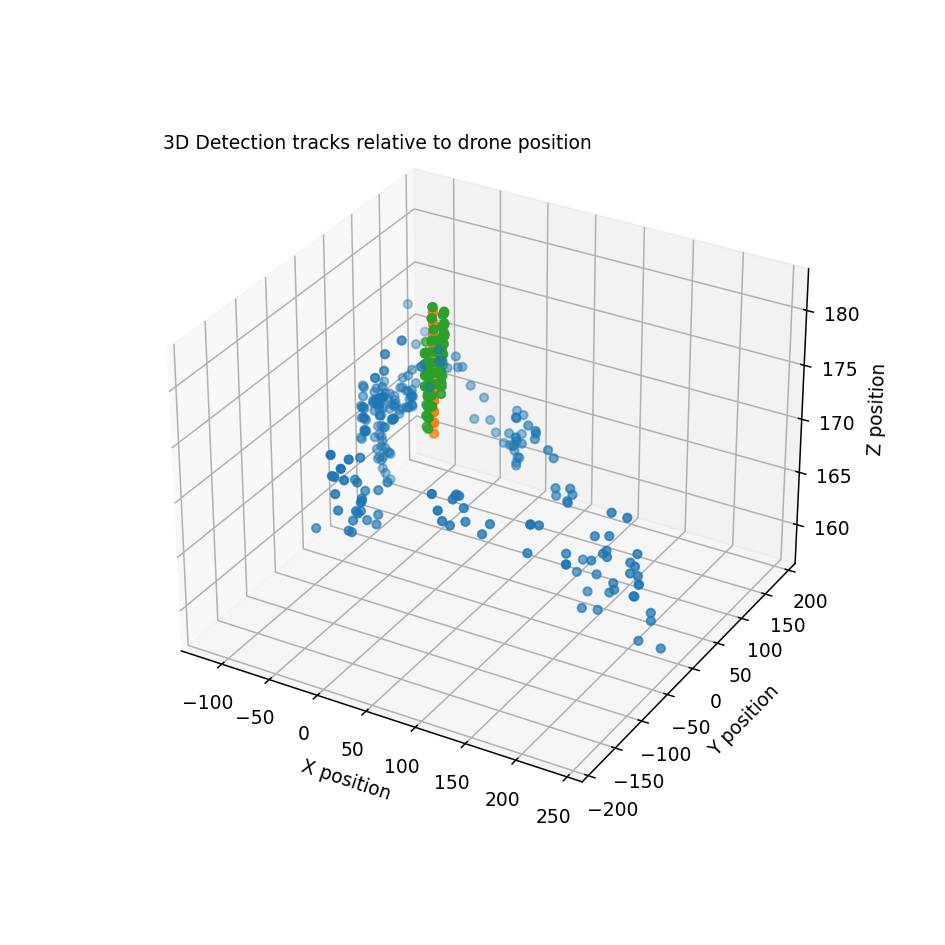

In [14]:
%matplotlib notebook
fig4 = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points
thetaDet=theta[personCount>0]
yawDet=yaw[personCount>0]
estimatedDistanceDet=estimatedDistance[personCount>0]
tofDet=tof[personCount>0]
yPosDet=yPos[personCount>0]
thetaf=np.array(thetaDet[telSeqId==seqId])
yawf=np.array(yawDet[telSeqId==seqId])
estimatedDistancef=np.array(estimatedDistanceDet[telSeqId==seqId])
toff=np.array(tofDet[telSeqId==seqId])
yPosf=np.array(yPosDet[telSeqId==seqId])


zdata = toff-yPosf
xdata = estimatedDistancef*np.cos((yawf+thetaf)*np.pi/180) 
ydata = estimatedDistancef*np.sin((yawf+thetaf)*np.pi/180) 
zdrone = toff
xdrone = np.zeros((len(toff),1))
ydrone = np.zeros((len(toff),1))
zcamera = toff
xcamera = 10*np.cos((yawf)*np.pi/180) 
ycamera = 10*np.sin((yawf)*np.pi/180) 
ax.scatter3D(xdata, ydata, zdata,'r')
ax.scatter3D(xdrone, ydrone, zdrone)
ax.scatter3D(xcamera, ycamera, zcamera)
ax.text2D(0.05, 0.95, "3D Detection tracks relative to drone position", transform=ax.transAxes)
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
plt.savefig("out/jpg/spotlight3d/polar-map-3d.jpg",dpi=dpiSelected)



### Animation: 3D Detection tracks relative to drone position <a class="anchor" id="3d-animation"></a>

<IPython.core.display.Javascript object>


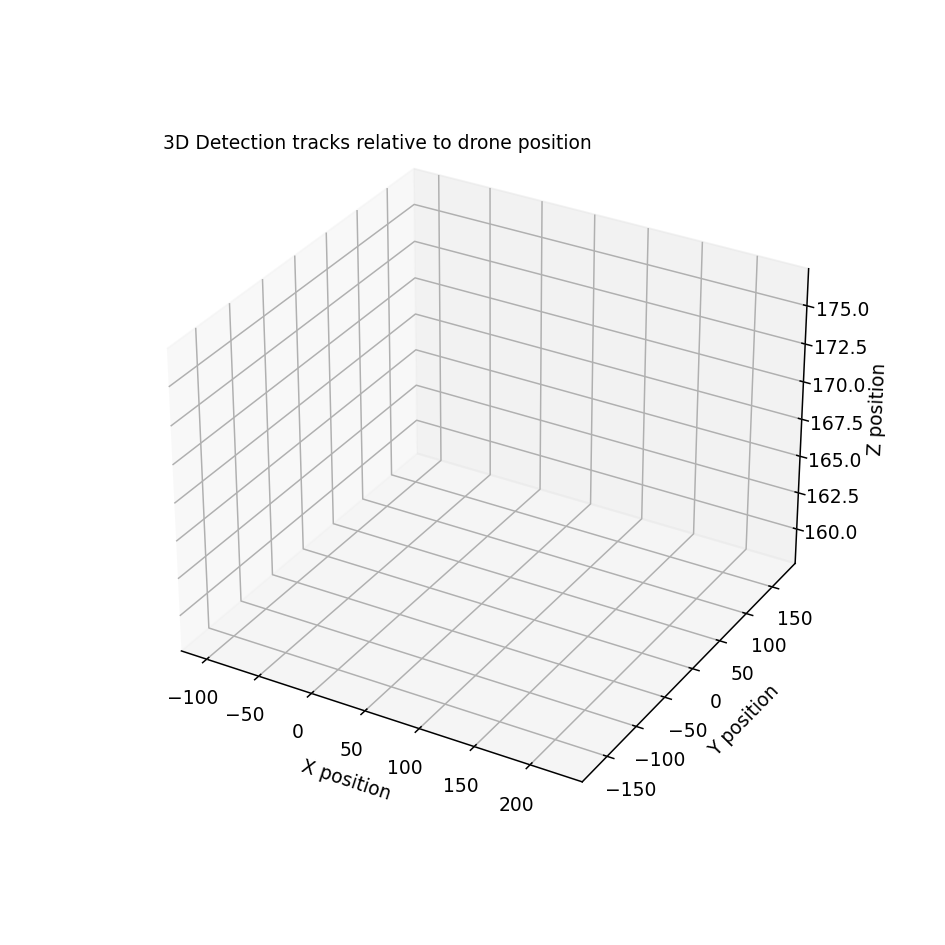

In [15]:
%matplotlib notebook
fig5 = plt.figure(figsize=(7,7))
ax = fig5.add_subplot(111,projection='3d')
#ax = plt.axes(projection='3d')
thetaf=np.array(theta[(telSeqId==seqId)&(personCount>0)])
yawf=np.array(yaw[(telSeqId==seqId)&(personCount>0)])
estimatedDistancef=np.array(estimatedDistance[(telSeqId==seqId)&(personCount>0)])
toff=np.array(tof[(telSeqId==seqId)&(personCount>0)])
yPosf=np.array(yPos[(telSeqId==seqId)&(personCount>0)])
 
def draw_data3(i):       
    # Clear
    ax.cla()
    ax.scatter3D(xdata[i:i+19],ydata[i:i+19],zdata[i:i+19],'ko')
    ax.set_xlim(np.min(xdata),np.max(xdata))
    ax.set_ylim(np.min(ydata),np.max(ydata))
    ax.set_zlim(np.min(zdata),np.max(zdata))
    ax.scatter3D(xdrone[i:i+19], ydrone[i:i+19], zdrone[i:i+19])
    ax.scatter3D(xcamera[i:i+19], ycamera[i:i+19], zcamera[i:i+19])
    ax.text2D(0.05, 0.95, "3D Detection tracks relative to drone position", transform=ax.transAxes)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')


anim = animation.FuncAnimation(fig5, draw_data3, interval=100, frames=len(telSeqId==id)-20)    
plt.show()

## Telemetry Data Explanation <a class="anchor" id="data-explanation"></a>

### timestamp 
Data timestamp (milliseconds).

### trackMode
Tracking Mode coded as follows:

0 -> None, 
1 -> Spotlight,
2 -> Follow,
3 -> Orbit, 
4 -> Profile, 
5 -> Party,
6 -> Forward with person avoidance.

### telSeqId
An incremental number used to manually mark flight phases. Use the Tello Vision 1D app button "Tel ID ++" to mark sequences of interest.

### personCount
Detected person count.

### personConfidence
Detection confidence for the foreground person (%).

### faceXPx, faceYPx, faceRadiusPx
Detection center and apparent face radius for the foreground person (pixels).

### angle_err
Horizontal angle error between the detected face and the center of the image (degrees)

### estimatedDistance
3D Distance between the drone and the detected face (cm).

### estimatedXPos, estimatedYPos, estimatedZPos
estimatedDistance decomposed in the (X,Y,Z) drone frame reference (cm).

X is in the drone right direction, Y is in the drone down direction, Z is in the drone forward direction.

### Uyaw, Uz, Ux, Uy
Speed commands sent to the drone (approximated deg/s and cm/s)

### pitch, roll, yaw
Eulerian angles from the IMU (degrees).

### vx, vy, vz
Velocities from the IMU (decimeter/s).

X is drone's initial forward direction, Y is drone's initial right direction, Z is drone's down direction.

### tof
Drone height from the Time Of Flight sensor (cm).

### batt
Drone battery level (%).

### temp
Drone temperature (°C).

## Telemetry Data Filtering <a class="anchor" id="data-filtering"></a>
Displaying many minutes of telemetry data all in the same plot can be difficult to interpret.
The key is to filter and select data to make the analysis simpler.
It is possible to leverage Python powerful Pandas Data Analysis Library and Tello Vision Telemetry Lab data columns definition.
For example, the trackMode column classifies data by the flight tracking mode active in each moment.
Autonomous tracking modes are coded as follows:
0 -> None, 
1 -> Spotlight,
2 -> Follow,
3 -> Orbit, 
4 -> Profile, 
5 -> Party,
6 -> Forward with person avoidance.

So the following lines  of code:

*tofFollow=(tof[trackMode==2])*

*tofOrbit=(tof[trackMode==3])*

select only Time of Flight data of the Follow mode and the Orbit mode giving the possibility to plot them in two separate figures.